# Show iterative steps of preprocessing

In [25]:
import data_utils
import numpy as np
import matplotlib.pyplot as plt
from preprocessing import binarize_per_slice, all_slice_analysis, fill_hole, two_lung_only, process_mask

(133, 512, 512)


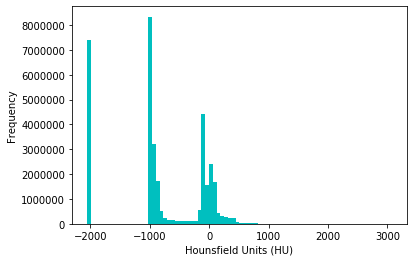

In [21]:
# Show iterative steps of computing lung mask
first_patient_pixels, spacing, _ = data_utils.load_dicom_slices("../../data/LIDC-IDRI-DCM/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/")
print(first_patient_pixels.shape)
import matplotlib.pyplot as plt
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

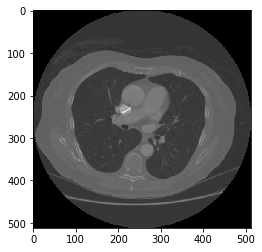

In [14]:
# Show some slice in the middle
h = 80
plt.imshow(first_patient_pixels[h], cmap=plt.cm.gray)
plt.show()

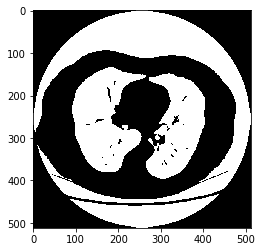

In [15]:
bw = binarize_per_slice(first_patient_pixels, spacing)
plt.imshow(bw[h], cmap=plt.cm.gray)
plt.show()

Parallélisé mais très long sur Power (de l'ordre de 2 minutes).

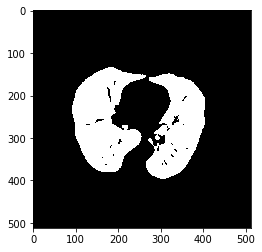

In [16]:
flag = 0
cut_num = 0
while flag == 0:
    bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num)
    cut_num = cut_num + 1
plt.imshow(bw[h], cmap=plt.cm.gray)
plt.show()

Pas de multiprocessing.

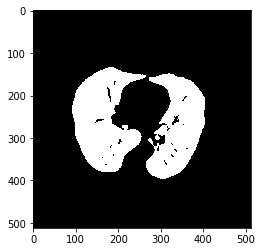

In [18]:
bw = fill_hole(bw)
plt.imshow(bw[h], cmap=plt.cm.gray)
plt.show()

Pas de multiprocessing.

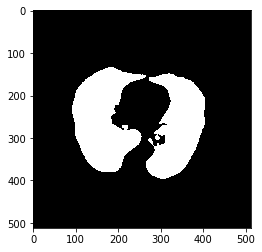

In [19]:
bw1, bw2, bw = two_lung_only(bw, spacing)
plt.imshow(bw[h], cmap=plt.cm.gray)
plt.show()

Pas de multiprocessing. Plutôt long.

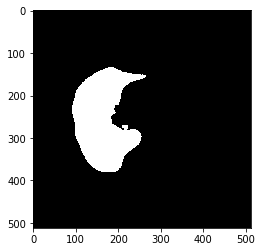

In [22]:
plt.imshow(bw1[h], cmap=plt.cm.gray)
plt.show()

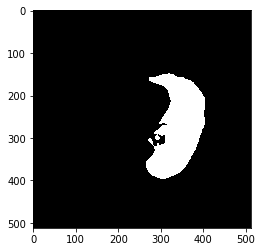

In [23]:
plt.imshow(bw2[h], cmap=plt.cm.gray)
plt.show()

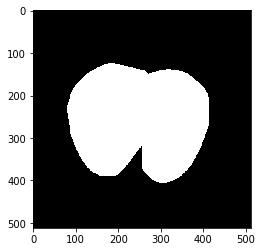

In [29]:
dm1 = process_mask(bw1)
dm2 = process_mask(bw2)
plt.imshow(dm1[h]+dm2[h], cmap=plt.cm.gray)
plt.show()

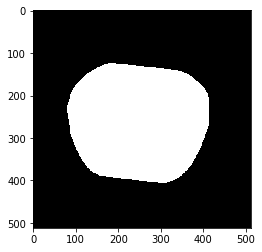

In [28]:
dm = process_mask(bw)
plt.imshow(dm[h], cmap=plt.cm.gray)
plt.show()

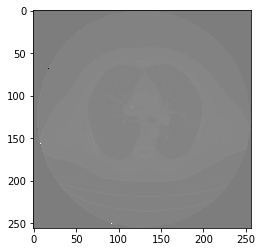

In [33]:
x = np.load("/wmlce/data/projects/lung_segmentation/output/preprocessing/2_128_256_256/456.npy")
plt.imshow(x[h], cmap=plt.cm.gray)
plt.show()

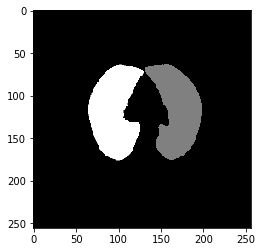

In [34]:
x_mask = np.load("/wmlce/data/projects/lung_segmentation/output/preprocessing/2_128_256_256/456_mask.npy")
plt.imshow(x_mask[h], cmap=plt.cm.gray)
plt.show()

# Using U-Net Lungs Segmentation

In [2]:
import os
import sys
import time
import torch
import mlflow
import mlflow.pytorch
import numpy as np
import SimpleITK as sitk
from pathlib import Path
import matplotlib.pyplot as plt
os.environ['MDT_DATASETS_DIR'] = '/wmlce/data/medical-datasets'
from preprocessing import binarize_per_slice, all_slice_analysis, fill_hole, two_lung_only, process_mask, resample_array, lumTrans

LS_PATH = os.path.join('.', 'lung-segmentation')
sys.path.append(LS_PATH)
import predict
from data import utils as data_utils

ModuleNotFoundError: No module named 'nrrd'

LIDC-IDRI-0489: loaded in 0.800269603729248 s
LIDC-IDRI-0489: Resampled in 7.422248363494873 s
LIDC-IDRI-0489: (282, 514, 514), (0.7, 0.7, 1.25)


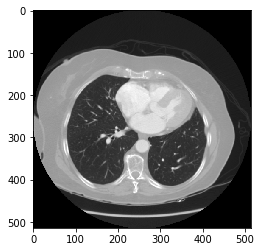

In [52]:
start_time = time.time()
pid = 'LIDC-IDRI-0489'
path = f'/wmlce/data/medical-datasets/MDT-LIDC-IDRI/NRRDs/{pid}'
target_spacing = (0.7, 0.7, 1.25)
remote_server_uri = "http://mlflow.10.7.13.202.nip.io/"
mlflow.set_tracking_uri(remote_server_uri)
h = 150

# Load scan
img = sitk.ReadImage(os.path.join(path, '{}_CT.nrrd'.format(pid)))
original_spacing = np.array(img.GetSpacing())
img_arr = sitk.GetArrayFromImage(img)
ls_img_arr = np.copy(img_arr)


load_time = time.time()
print(f'{pid}: loaded in {load_time - start_time} s')

# Resample and Normalize
img_arr = resample_array(img_arr, img.GetSpacing(), target_spacing)
lum_img_arr = np.copy(img_arr)
img_arr = np.clip(img_arr, -1200, 600)
img_arr = img_arr.astype(np.float32)
img_arr = (img_arr - np.mean(img_arr)) / np.std(img_arr).astype(np.float16)

norm_time = time.time()
print(f'{pid}: Resampled in {norm_time - load_time} s')
print(f'{pid}: {img_arr.shape}, {target_spacing}')
plt.imshow(img_arr[h], cmap=plt.cm.gray)
plt.show()

(141, 512, 512) [0.703125 0.703125 2.5     ]
(1, 128, 256, 256) [0.7745361328125, 1.40625, 5.0]
(1, 1, 128, 256, 256) [0.7745361328125, 1.40625, 5.0]
(282, 514, 514) (0.7, 0.7, 1.25)
LIDC-IDRI-0489: Lung segmentation took 19.15325379371643 s


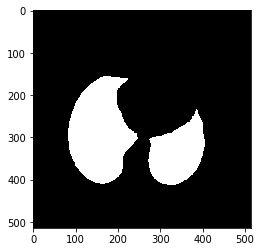

In [53]:
# Compute lungs mask
model_name = "2-lungs-segmentation"
unet = mlflow.pytorch.load_model("models:/{}/production".format(model_name))
print(ls_img_arr.shape, original_spacing)
ls_img_arr, spacing = data_utils.prep_img_arr(ls_img_arr, original_spacing)
print(ls_img_arr.shape, spacing)
mask = predict.predict(ls_img_arr, 1, unet, threshold=True, erosion=True)
print(mask.shape, spacing)
mask, spacing = data_utils.prep_img_arr(mask[0][0], spacing, target_shape=img_arr.shape)
mask = mask[0]
mask[mask>0.5] = 1
mask[mask!=1] = 0
print(mask.shape, target_spacing)

ls_time = time.time()
print(f'{pid}: Lung segmentation took {ls_time - norm_time} s')

plt.imshow(mask[h], cmap=plt.cm.gray)
plt.show()

LIDC-IDRI-0489: Cleaning took 122.31686472892761 s
LIDC-IDRI-0489: Ellapsed 149.69283413887024 s


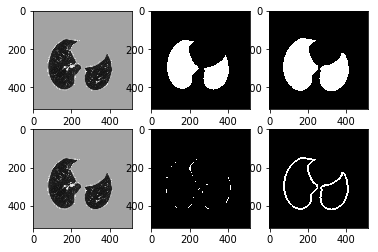

In [58]:
dilatedMask = process_mask(mask)
Mask = mask
extramask = dilatedMask.astype(np.uint8) - Mask.astype(np.uint8)
bone_thresh = 210
pad_value = 1  #170
img_arr[np.isnan(img_arr)]=-2000
sliceim = lumTrans(lum_img_arr)
#sliceim = sliceim*dilatedMask+pad_value*(1-dilatedMask).astype('uint8')
bones = sliceim*extramask>bone_thresh
#sliceim[bones] = pad_value

img_arr = img_arr*dilatedMask+pad_value*(1-dilatedMask).astype('uint8')
img_arr[bones] = pad_value

bones_mask = np.zeros(sliceim.shape)
bones_mask[bones] = 1

print(f'{pid}: Cleaning took {time.time() - ls_time} s')
print(f'{pid}: Ellapsed {time.time() - start_time} s')

# Plot image
plt.subplot(2, 3, 1).imshow(img_arr[h], cmap=plt.cm.gray)
plt.subplot(2, 3, 2).imshow(Mask[h], cmap=plt.cm.gray)
plt.subplot(2, 3, 3).imshow(dilatedMask[h], cmap=plt.cm.gray)
plt.subplot(2, 3, 4).imshow(img_arr[h], cmap=plt.cm.gray)
plt.subplot(2, 3, 5).imshow(bones_mask[h], cmap=plt.cm.gray)
plt.subplot(2, 3, 6).imshow(extramask[h], cmap=plt.cm.gray)
plt.show()

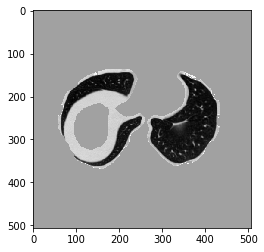

In [9]:
dir_path = "/wmlce/data/medical-datasets/MDT-PP"
imgs = glob.glob(os.path.join(dir_path, "*_rois.npy"))
print(np.min(img_arr), np.max(img_arr))
plt.imshow(img_arr[h], cmap=plt.cm.gray)
plt.show()

## Load some images generated by such preprocessing

In [60]:
import os, glob
import numpy as np
import matplotlib.pyplot as plt

Image LIDC-IDRI-0801_rois (236, 380, 380), rois (236, 380, 380)
Image LIDC-IDRI-0954_rois (242, 575, 575), rois (242, 575, 575)
Image LIDC-IDRI-0052_rois (272, 542, 542), rois (272, 542, 542)
Image LIDC-IDRI-0552_rois (270, 407, 407), rois (270, 407, 407)
Image LIDC-IDRI-0035_rois (266, 599, 599), rois (266, 599, 599)
Image LIDC-IDRI-0337_rois (280, 413, 413), rois (280, 413, 413)
Image LIDC-IDRI-0382_rois (254, 443, 443), rois (254, 443, 443)
Image LIDC-IDRI-0747_rois (266, 407, 407), rois (266, 407, 407)
Image LIDC-IDRI-0235_rois (278, 514, 514), rois (278, 514, 514)
Image LIDC-IDRI-0824_rois (264, 471, 471), rois (264, 471, 471)


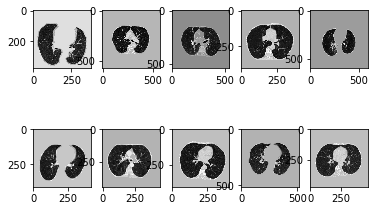

In [72]:
dir_path = "/wmlce/data/medical-datasets/MDT-PP"
imgs = glob.glob(os.path.join(dir_path, "*_rois.npy"))
h = 150
n = 10
for ix, img in enumerate(np.random.choice(imgs, n), 1):
    img_arr = np.load(img.replace("_rois", "_img")).astype(np.float32)
    rois_arr = np.load(img)
    print(f"Image {os.path.splitext(os.path.basename(img))[0]} {img_arr.shape}, rois {rois_arr.shape}")
    plt.subplot(2, n/2, ix).imshow(img_arr[h], cmap=plt.cm.gray)
plt.show()

In [65]:
dir_path = "/wmlce/data/medical-datasets/MDT-PP"
img = "LIDC-IDRI-0338_img.npy"
img = "LIDC-IDRI-0479_img.npy"
img = "LIDC-IDRI-0489_img.npy"
img = "LIDC-IDRI-0015_img.npy"
img = "LIDC-IDRI-0509_img.npy" # This image seems to have been swapped (axes issues / flipped ?)
img_arr = np.load(os.path.join(dir_path, img))
print(img_arr.shape, img_arr.dtype)
plt.imshow(img_arr[:,250,:], cmap=plt.cm.gray)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/wmlce/data/medical-datasets/MDT-PP/LIDC-IDRI-0509_img.npy'

# Crap image analysis

### Resample to original size and save to nrrd

In [12]:
from preprocessing import resample_array_to_shape
itkimg = sitk.ReadImage("/wmlce/data/medical-datasets/LIDC-IDRI/LIDC-IDRI-0015/1.3.6.1.4.1.14519.5.2.1.6279.6001.231462296937187240061810311146/1.3.6.1.4.1.14519.5.2.1.6279.6001.227962600322799211676960828223/LIDC-IDRI-0015_CT.nrrd")
seg_mask, seg_spacing = resample_array_to_shape(img_arr, [0.7,0.7,1.25], target_shape=sitk.GetArrayFromImage(itkimg).shape)
new_itk = sitk.GetImageFromArray(seg_mask)
new_itk.SetOrigin(itkimg.GetOrigin())
new_itk.SetSpacing(itkimg.GetSpacing())
sitk.WriteImage(new_itk, 'test.nrrd')

# Get list of all images with high spacing / flipped images

In [4]:
import nrrd
import os, glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt

def load_itk(filename):
    with open(filename) as f:
        contents = f.readlines()
        line = [k for k in contents if k.startswith('TransformMatrix')][0]
        transformM = np.array(line.split(' = ')[1].split(' ')).astype('float')
        transformM = np.round(transformM)
        if np.any( transformM!=np.array([1,0,0, 0, 1, 0, 0, 0, 1])):
            isflip = True
        else:
            isflip = False

    itkimage = sitk.ReadImage(filename)
    numpyImage = sitk.GetArrayFromImage(itkimage)

    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))

    return numpyImage, numpyOrigin, numpySpacing, isflip
list_path = glob.glob("/wmlce/data/medical-datasets/LIDC-IDRI/LIDC-IDRI-*/*/*/*_CT.nrrd")

In [5]:
spaces = set([])
kinds = set([])
dimensions = set([])
high_spacing = set([])
for path in list_path:
    h = nrrd.read_header(path)
    spaces.add(h['space'])
    for k in h['kinds']:
        kinds.add(k)
    dimensions.add(h['dimension'])
    if np.max(h['space directions']) > 2.5:
        high_spacing.add(path)

In [6]:
print(spaces)
print(kinds)
print(dimensions)
print(len(high_spacing))

{'left-posterior-superior'}
{'domain'}
{3}
143


# Check scans manually

In [22]:
import nrrd
import os, glob
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual
from IPython.display import display
import matplotlib.pyplot as plt
import ipywidgets as widgets

In [25]:
ix = 0
#list_path = glob.glob("/wmlce/data/medical-datasets/LIDC-IDRI/LIDC-IDRI-*/*/*/*_CT.nrrd")
list_path = glob.glob("/wmlce/data/medical-datasets/MDT-PP/*_img.npy")

import csv
#csv_path = 'scans_checkup.csv'
csv_path = 'pp_scans_checkup.csv'
header = ['pid', 'flip', 'crap', 'poor', 'warn', 'note']
if not os.path.exists(csv_path):
    f = open(csv_path, 'w+')
    writer = csv.DictWriter(f, fieldnames=header)
    writer.writeheader()
    f.close()

def f(flip, crap, poor, warn, note):
    global ix, list_path, csv_path, header
    if ix >= 1 and (flip or crap or poor or warn):
        #pid = os.path.splitext(os.path.basename(list_path[ix-1]))[0].split('_CT')[0]
        pid = os.path.splitext(os.path.basename(list_path[ix-1]))[0].split('_img')[0]
        print(f'Adding abnormal img {pid} to csv')
        f = open(csv_path, 'a')
        writer = csv.DictWriter(f, fieldnames=header)
        writer.writerow({header[0]: pid, header[1]: int(flip), header[2]: int(crap), header[3]: int(poor), header[4]: int(warn), header[5]: note})
        f.close()
    if ix >= 0 and ix < len(list_path):
        print(f'Showing img: {ix}: {list_path[ix]}')
        ## Show ITK
        #itkimage = sitk.ReadImage(list_path[ix])
        #numpyImage = sitk.GetArrayFromImage(itkimage)
        numpyImage = np.load(list_path[ix])
        plt.imshow(numpyImage[int(len(numpyImage)/2)].astype(np.uint8), cmap=plt.cm.gray)
        plt.show()
    elif ix >= 0:
        print('Done')
    ix = ix + 1

_ = interact_manual(f, flip=False, crap=False, poor=False, warn=False, note='')

interactive(children=(Checkbox(value=False, description='flip'), Checkbox(value=False, description='crap'), Ch…

# Check ROI labels

In [2]:
import os, glob
import numpy as np

In [3]:
list_paths = glob.glob("/wmlce/data/medical-datasets/MDT-PP/*_rois.npy")
for path in list_paths[:10]:
    arr = np.load(path)
    pid = os.path.splitext(os.path.basename(path))[0].split('_')[0]
    print(pid, np.unique(arr))

LIDC-IDRI-0730 [0 1]
LIDC-IDRI-0096 [0 1]
LIDC-IDRI-0941 [0 1]
LIDC-IDRI-0272 [0 1]
LIDC-IDRI-0921 [0 1 2 3 4 5]
LIDC-IDRI-0674 [0 1 2 3 4 5]
LIDC-IDRI-0271 [0 1]
LIDC-IDRI-0341 [0 1 2 3 4 5 6]
LIDC-IDRI-0892 [0 1 2 3 4]
LIDC-IDRI-0970 [0]


## Upsample ROIs to original scan size for visualization

In [33]:
os.environ["MDT_DATASETS_DIR"] = "/wmlce/data/medical-datasets"
from preprocessing import resample_array_to_shape
import numpy as np
import os, glob
itkimg = sitk.ReadImage(glob.glob("/wmlce/data/medical-datasets/LIDC-IDRI/LIDC-IDRI-0806/*/*/*_CT.nrrd")[0])
rois_path = "/wmlce/data/medical-datasets/MDT-PP/LIDC-IDRI-0806_rois.npy"
pid = os.path.splitext(os.path.basename(rois_path))[0].split('_')[0]
rois_arr = np.load(rois_path)
rois_arr[rois_arr != 0] = 1
seg_mask, seg_spacing = resample_array_to_shape(rois_arr, [0.7,0.7,1.25], target_shape=sitk.GetArrayFromImage(itkimg).shape)
seg_mask[seg_mask >= 0.5] = 1
seg_mask[seg_mask < 0.5] = 0
seg_mask = seg_mask.astype(np.uint8)
new_itk = sitk.GetImageFromArray(seg_mask)
new_itk.SetOrigin(itkimg.GetOrigin())
new_itk.SetSpacing(itkimg.GetSpacing())
sitk.WriteImage(new_itk, f'{pid}_rois.nrrd')